# Coup Results Prediction with Classification Models

### Shunji Wan, 11/06/2022

<a id="0"></a> <br>
 # Table of Contents  
- [Problem Statement](#1)
- [Data Collection and Processing](#2)
    1. [The _Coup D'etat Project (CDP)_ Dataset](#3)
    2. [The _Rulers, Elections, and Irregular Governance (REIGN)_ Dataset](#4)
    3. [Data Merging](#5)
- [Feature Engineering](#6)
    1. [Appending Additional Features](#7)
    2. [Missing Values Imputation](#8)
- [Exploratory Data Analysis](#9)

<a id="1"></a> <br>
## Problem Statement

In modern times, coups refer to the sudden seizure of governmental power through non-institutional ways.

Coups are relatively rare compared with the mundane traditions in everyday politics. They are not sechduled like elections, nor are they publicized beforehand like protests. Coups are secretly planned and executed by only a small faction of the entire population in a country.

Politicians are concerned with coups as they could overthrow regimes and thus lead to geopolitical impacts, and investors care about coups as their local economic interests may be negatively impacted - whatever the results of the coups are, they often entail violence and are hugely impactful on people’s lives, not only in the country where the coup takes place but also in countries that are closely connected to it, economically, politically, or culturally, for coups change what is considered as the norm. The irregularity and the unexpected huge impacts of coups motivate data scientists to uncover patterns in coups.

In our project, we try to predict the outcome of a coup at an early stage, using information that can be acquired at the beginning of the coup, for example, the type of the coup and the GDP growth in that country in that year. We ask:

- __*Can we make accurate predictions of the coup result with only selected information?*__
- __*Which factors are the most influential in determining whether a result will succeed?*__

Being able to predict whether a coup will succeed at the beginning is important as it allows policymakers to act ahead of time. To this end, we incorporate several data sources. We mainly rely on the __Coup D'etat Project (CDP)__ for a comprehensive list of 943 coups from 1949 to 2019. The CDP dataset distinguishes 10 types of coups that are realized, unrealized or unsubstantiated (in conspiracy only). Then we use the __Rulers, Elections, and Irregular Governance (REIGN)__ dataset to determine specific characteristics of the country where the coup takes place. For example, the length of the government leader’s tenure, the length of democracy, and the time since the last election. Furthermore, we include population data from __Oxford University__ and commodity prices from __World Bank__.


<a id="2"></a> <br>
## Data Collection and Processing

In [1]:
import pandas as pd
import numpy as np

Since our data come from various sources, our first step is to walk through all datasets and explore, delete redundant information, check needs for one-hot encoding, and fix missing values if needed.

<a id="3"></a> <br>
### 1. The _Coup D'etat Project (CDP)_ Data

In [2]:
cdf_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/Coup_Data_v2.0.0.csv")
cdf_df.head(3)

,coup_id,cowcode,country,year,month,day,event_type,unrealized,realized,conspiracy,...,counter,other,noharm,injured,killed,harrest,jailed,tried,fled,exile
0,43910302014,439,Burkina Faso,2014,10,30,coup,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,51605132015,516,Burundi,2015,5,13,attempted,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,48304132006,483,Chad,2006,4,13,attempted,1,0,0,...,0,0,1,0,0,0,0,0,0,0


This dataset includes information concerning where and when the coups took place, results and types of coups.

In [3]:
cdf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   coup_id     943 non-null    object
 1   cowcode     943 non-null    int64 
 2   country     943 non-null    object
 3   year        943 non-null    int64 
 4   month       943 non-null    int64 
 5   day         943 non-null    int64 
 6   event_type  943 non-null    object
 7   unrealized  943 non-null    int64 
 8   realized    943 non-null    int64 
 9   conspiracy  943 non-null    int64 
 10  attempt     943 non-null    int64 
 11  military    943 non-null    int64 
 12  dissident   943 non-null    int64 
 13  rebel       943 non-null    int64 
 14  palace      943 non-null    int64 
 15  foreign     943 non-null    int64 
 16  auto        943 non-null    int64 
 17  resign      943 non-null    int64 
 18  popular     943 non-null    int64 
 19  counter     943 non-null    int64 
 20  other     

Luckily, our __CDP__ dataset does not contain any `null`. Therefore, there is no need for us to worry about missing values.

Next, we print out some descriptive statistics and take a look at ratios of all kinds of coup events.

In [4]:
for i in range(7,21):
    np_col = cdf_df.iloc[:,i].to_numpy()
    num_obs = np.sum(np_col)
    txt = "Ratio of {type} coup events: {numer}/{denom}."
    print(txt.format(type=cdf_df.columns[i],numer=num_obs,denom=len(cdf_df)))

Ratio of unrealized coup events: 517/943.
Ratio of realized coup events: 426/943.
Ratio of conspiracy coup events: 181/943.
Ratio of attempt coup events: 335/943.
Ratio of military coup events: 559/943.
Ratio of dissident coup events: 273/943.
Ratio of rebel coup events: 59/943.
Ratio of palace coup events: 120/943.
Ratio of foreign coup events: 66/943.
Ratio of auto coup events: 32/943.
Ratio of resign coup events: 81/943.
Ratio of popular coup events: 93/943.
Ratio of counter coup events: 19/943.
Ratio of other coup events: 3/943.


We start to clean our dataset. At first, we remove all observations that are conspiracies, because coup instances are our focus. Afterwards, `conspiracy` column can be deleted. Then, we drop the last 8 columns, as they are results of a coup, which cannot help us make prediction ahead.

As for coup types, we only focus on `military` coups, because other types are rare and hard to discern at the early stage of the coup. We further remove `event_type`, `unrealized`, and `attempt`. They are repetitive information as they can all be inferred from `realized`.

There is no need for one-hot encoding, as all categorical variables are binary, and their values are either 1 or 0.

In [5]:
cdf_df = cdf_df[cdf_df["conspiracy"]==0].iloc[:,:12].drop(["event_type","unrealized","conspiracy","attempt"],axis=1).reset_index(drop=True)
cdf_df.head(3)

,coup_id,cowcode,country,year,month,day,realized,military
0,43910302014,439,Burkina Faso,2014,10,30,1,1
1,51605132015,516,Burundi,2015,5,13,0,1
2,48304132006,483,Chad,2006,4,13,0,0


<a id="4"></a> <br>
### 2. The _Rulers, Elections, and Irregular Governance (REIGN)_ Dataset

Next, we start to explore the __REIGN__ dataset. This dataset is very different from the __CDP__ dataset, as it has nothing to do with coups - the __REIGN__ dataset contains information concerning the political leadership, regime characteristics and electoral outcomes for every country around the globe since January 1950. However, it could offer us more attributes that could help with our coup results prediction.

In [6]:
reign_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/REIGN_2021_8.csv")
reign_df.head(3)

,ccode,country,leader,year,month,elected,age,male,militarycareer,tenure_months,...,lastelection,loss,irregular,political_violence,prev_conflict,pt_suc,pt_attempt,precip,couprisk,pctile_risk
0,2.0,USA,Truman,1950.0,1.0,1.0,66.0,1,0.0,58.0,...,2.639057,5.327876,7.565793,-0.36429,0.0,0.0,0.0,-0.059930,NaN,NaN
1,2.0,USA,Truman,1950.0,2.0,1.0,66.0,1,0.0,59.0,...,2.708050,5.332719,7.566311,-0.36429,0.0,0.0,0.0,-0.113721,NaN,NaN
2,2.0,USA,Truman,1950.0,3.0,1.0,66.0,1,0.0,60.0,...,2.772589,5.337538,7.566829,-0.36429,0.0,0.0,0.0,-0.108042,NaN,NaN


In [7]:
reign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138600 entries, 0 to 138599
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ccode               138600 non-null  float64
 1   country             138600 non-null  object 
 2   leader              138600 non-null  object 
 3   year                138600 non-null  float64
 4   month               138600 non-null  float64
 5   elected             138600 non-null  float64
 6   age                 138600 non-null  float64
 7   male                138600 non-null  int64  
 8   militarycareer      138600 non-null  float64
 9   tenure_months       138600 non-null  float64
 10  government          138600 non-null  object 
 11  gov_democracy       138600 non-null  float64
 12  dem_duration        138600 non-null  float64
 13  anticipation        138600 non-null  float64
 14  ref_ant             138600 non-null  float64
 15  leg_ant             138600 non-nul

This dataset is massive - there are tons of observations as well as features!

Hence, instead of removing unnecessary information, this time we pick only features that we deem relevant to our research questions based on our knowledge in political science. The codebook of this dataset provides comprehensive definitions all the headers.

The following are the selected variables. Again, there is no need for one-hot encoding or fixing missing values.

In [43]:
selected_features = ["ccode","country","leader","year","month","age","militarycareer",
                     "tenure_months","gov_democracy","dem_duration","anticipation",
                     "change_recent","political_violence","precip"]
reign_df = reign_df[selected_features]
reign_df.head(3)

,ccode,country,leader,year,month,age,militarycareer,tenure_months,gov_democracy,dem_duration,anticipation,change_recent,political_violence,precip
0,2.0,USA,Truman,1950.0,1.0,66.0,0.0,58.0,1.0,5.086567,0.0,0.0,-0.36429,-0.059930
1,2.0,USA,Truman,1950.0,2.0,66.0,0.0,59.0,1.0,5.087082,0.0,0.0,-0.36429,-0.113721
2,2.0,USA,Truman,1950.0,3.0,66.0,0.0,60.0,1.0,5.087596,0.0,0.0,-0.36429,-0.108042


<a id="5"></a> <br>
### 3. Data Merging

After finishing cleaning the __CDP__ and __REIGN__ datasets, we merge them using `cowcode`, `country`, `year`, `month` as keys to obtain a comprehensive table that includes coup events with all selected features so far.

Then, we take a look at our cleaned, merged dataset.

In [8]:
merged_df = cdf_df.merge(reign_df, how='left',
                         left_on=['cowcode','country','year','month'],
                         right_on=['ccode','country','year','month']).drop("ccode",axis=1)
merged_df.head()

,coup_id,cowcode,country,year,month,day,realized,military,leader,age,militarycareer,tenure_months,gov_democracy,dem_duration,anticipation,change_recent,political_violence,precip
0,43910302014,439,Burkina Faso,2014,10,30,1,1,Campaore,63.0,1.0,325.0,0.0,0.000000,1.0,0.0,-0.361354,0.207165
1,51605132015,516,Burundi,2015,5,13,0,1,Nkurunziza,51.0,0.0,118.0,1.0,2.374906,1.0,0.0,-0.209770,-0.257498
2,48304132006,483,Chad,2006,4,13,0,0,Deby,54.0,1.0,185.0,0.0,0.000000,1.0,0.0,-0.180390,0.085150
3,65102112011,651,Egypt,2011,2,11,1,1,Mubarak,82.0,1.0,353.0,0.0,0.000000,0.0,0.0,-0.364100,-0.584582
4,65102112011,651,Egypt,2011,2,11,1,1,Tantawi,76.0,1.0,1.0,0.0,0.000000,0.0,0.0,-0.364100,-0.584582


We can notice some problem here: the last two coup events are duplicates!

Why this happened? The leadership of a country changed during coups. Because Mohamed Hussein Tantawi ousted the former President of Egypt Hosni Mubarak in the coup on February 11th, 2011, for instance, the same coup record will present in our merged dataset twice. To address this issue, if there are observations with identical `coup_id`s, we keep the first and remove others.

In [9]:
def remove_duplicates(d):
    
    coup_id_lst = [] # store unique ids found so far
    row_lst = []     # lst of indices of rows with unique ids
    
    for i in range(0,len(d)):
        coup_id = d.loc[i,"coup_id"]
        if coup_id not in coup_id_lst: # if not duplicate
            coup_id_lst.append(coup_id)
            row_lst.append(i)
            
    return d.iloc[row_lst,:].reset_index(drop=True)

In [10]:
unique_df = remove_duplicates(merged_df)

Compare the `coup_id` columns of both `cdf_df` and `unique_df`. If return true, we successfully merged two tables!

In [11]:
print(cdf_df["coup_id"].equals(unique_df["coup_id"]))
print("There are in total {num} observations of coup events.".format(num=len(unique_df)))

True
There are in total 762 observations of coup events.


<a id="6"></a> <br>
## Feature Engineering

<a id="7"></a> <br>
### 1. Appending Additional Features

Now, we hope to add more information to our dataset, so that it can show, at some particlar time point, how well the economy did in countries where coups took place. After careful research, we deem __oil price__ and __population growth rate__ are some ideal indicators of economic performance (while we also considered GDP-related features, these data are significantly missing for enormous countries, especially those where coups regularly happen, in the last century). Therefore, we want to add those information to our dataset.

To that end, we found some data from __Oxford University__ and __World Bank__.

In [12]:
cmo_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/CMO.csv")
ppl_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/population.csv")

In [13]:
cmo_df.head(3)

,Unnamed: 0,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
0,1960M01,1.63,..,1.63,..,..,..,0.14,0.4,..,...,511.47,11.42,715.40,206.1,2180.4,1631.0,260.8,35.27,83.5,0.91
1,1960M02,1.63,..,1.63,..,..,..,0.14,0.4,..,...,511.47,11.42,728.19,203.7,2180.4,1631.0,244.9,35.27,83.5,0.91
2,1960M03,1.63,..,1.63,..,..,..,0.14,0.4,..,...,511.47,11.42,684.94,210.3,2173.8,1631.0,248.7,35.27,83.5,0.91


In [14]:
ppl_df.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,107195.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,694665117.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,39835428.0


After examining these datasets, we notice that they have missing values. Also, the earliest records of commodity prices and national population trace back to 1960. However, the __CDP__ dataset records coup observations since 1945. Hence, we may need to address the missing values problem.

Let's keep that in mind! Before doing that, we define a function, which allows us to create new columns `oil_price` and `population_growth` to our dataset and add values from the supplementary data as appropriate. If some data are unavailable, we assign their corresponding entries with `NA`s for now.

Notice, we want to add data concerning the __population growth rate__, but we only have the population data. Suppose we want to obtain the population growth rate in year $x$, we may do so using the following formula:

$$\mbox{population growth rate in }x=\frac{\mbox{population in }x-\mbox{population in }(x-1)}{\mbox{population in }(x-1)}.$$

We add the population growth rate in the preceding year when the coups happened, as when the coup is not yet ended, the population data of this year is unavailable. This also applies to the oil price data.

In [23]:
def add_features(d):
    
    c = d.copy() # make a copy to avoid destructive changes
    
    for i in range(0,len(c)): # iterate through coup observations
        str_country = c.loc[i,"country"]
        year = c.loc[i,"year"]
        month = c.loc[i,"month"]
        previous_year = str(year - 1)
        previous_pyear = str(year - 2)
        str_date = None
        
        if month < 10:
            str_date = previous_year + "M0" + str(month)
        else:
            str_date = previous_year + "M" + str(month)
            
        try: # if oil price of the country at some time is available, add it to c
            c.loc[i,"oil_price"] = cmo_df.loc[cmo_df.iloc[:,0]==str_date,"Crude oil, average"].values[0]
        except: pass # else, leave it blank
        
        try: # if population of the country at some time is available, add it to c
            population_pyear = ppl_df.loc[ppl_df["Country Name"]==str_country,previous_year].values[0]
            population_ppyear = ppl_df.loc[ppl_df["Country Name"]==str_country,previous_pyear].values[0]
            c.loc[i,"population_growth"] = (population_pyear - population_ppyear) / population_ppyear
        except: pass # else, leave it blank
        
    return c

Apply the function to our dataset. Then, we start to address those missing values.

In [44]:
add_df = add_features(unique_df)
add_df.head(3)

,coup_id,cowcode,country,year,month,day,realized,military,leader,age,militarycareer,tenure_months,gov_democracy,dem_duration,anticipation,change_recent,political_violence,precip,oil_price,population_growth
0,43910302014,439,Burkina Faso,2014,10,30,1,1,Campaore,63.0,1.0,325.0,0.0,0.000000,1.0,0.0,-0.361354,0.207165,105.43,0.030266
1,51605132015,516,Burundi,2015,5,13,0,1,Nkurunziza,51.0,0.0,118.0,1.0,2.374906,1.0,0.0,-0.209770,-0.257498,105.71,0.031865
2,48304132006,483,Chad,2006,4,13,0,0,Deby,54.0,1.0,185.0,0.0,0.000000,1.0,0.0,-0.180390,0.085150,50.64,0.037173


So far, we have all selected variables in our dataset, and we have also dropped redundant features. Therefore, while `realized` is the target variable - as it tells whether a coup succeeds or not - and the first 6 columns are identifiers, the rest of the variables are our predictors.

<a id="8"></a> <br>
### 2. Missing Values Imputation

In [30]:
from fancyimpute import IterativeImputer

To deal with the missing values in our dataset, we compute the number of missing entries for each observation and visualize it. If some rows have too many missing entries, it might be a good idea to just drop them. For the other rows with some missing entries, we may want to impute these values - so that information concerning other features will not be lost.

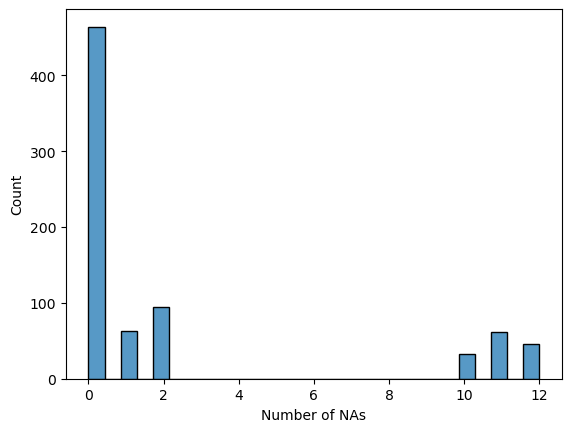

In [31]:
num_na_row = add_df.isnull().sum(axis=1)
sns.histplot(data=num_na_row).set(xlabel="Number of NAs")
plt.show()

Therefore in total 13 features, and some observations have more than 10 missing entries. These coup records provide us with too little information so we just drop them. Why do these events have more than 10 missing entries? We already checked that our truncated the __CDP__ and __REIGN__ datasets have no missing values. That is because information of some countries are not provided in the __REIGN__ dataset.

Once we removed these observations, we know that the rest of the missing entries belong to the `oil_price` and the `population_growth_rate` columns. Let's take a look at how many missing entries there are for each feature.

In [36]:
filtered_df = add_df[list(num < 10 for num in num_na_row)].reset_index(drop=True)
filtered_df = filtered_df.drop("leader",axis=1)
print("oil_price has {num} NAs.".format(num=filtered_df["oil_price"].isnull().sum()))
print("population_growth has {num} NAs.\n".format(num=filtered_df["population_growth"].isnull().sum()))
print("There are in total {num} observations in our dataset.".format(num=len(filtered_df)))

oil_price has 94 NAs.
population_growth has 157 NAs.

There are in total 621 observations in our dataset.


There is a significant number of missing values for each - given that there are in total 621 observations left. We may not want to replace those missing values with means or medians, as that is very likely to significantly change the distribution of our data.

Instead, we use the __multiple imputed chained equations (MICE)__ method. It counts for the "relationship" between the target feature and other features and meanwhile keeps the relative distribution similar before and after the imputation. After this, our dataset should be complete.

In [40]:
mice_imputer = IterativeImputer()
sliced_dp = filtered_df.iloc[:,7:]
array_imputed = mice_imputer.fit_transform(sliced_dp)
df_imputed = pd.DataFrame(array_imputed)

complete_df = filtered_df.copy()
complete_df[complete_df.columns[7:]] = df_imputed
complete_df.head(3)

,coup_id,cowcode,country,year,month,day,realized,military,age,militarycareer,tenure_months,gov_democracy,dem_duration,anticipation,change_recent,political_violence,precip,oil_price,population_growth
0,43910302014,439,Burkina Faso,2014,10,30,1,1.0,63.0,1.0,325.0,0.0,0.000000,1.0,0.0,-0.361354,0.207165,105.43,0.030266
1,51605132015,516,Burundi,2015,5,13,0,1.0,51.0,0.0,118.0,1.0,2.374906,1.0,0.0,-0.209770,-0.257498,105.71,0.031865
2,48304132006,483,Chad,2006,4,13,0,0.0,54.0,1.0,185.0,0.0,0.000000,1.0,0.0,-0.180390,0.085150,50.64,0.037173


<a id="9"></a> <br>
## Exploratory Data Analysis

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

As we obtained a complete dataset, we can start to explore the relationship between our target variable `realized` and our predictors. We may visualize the `realized` and each one of the predictors as appropriate.

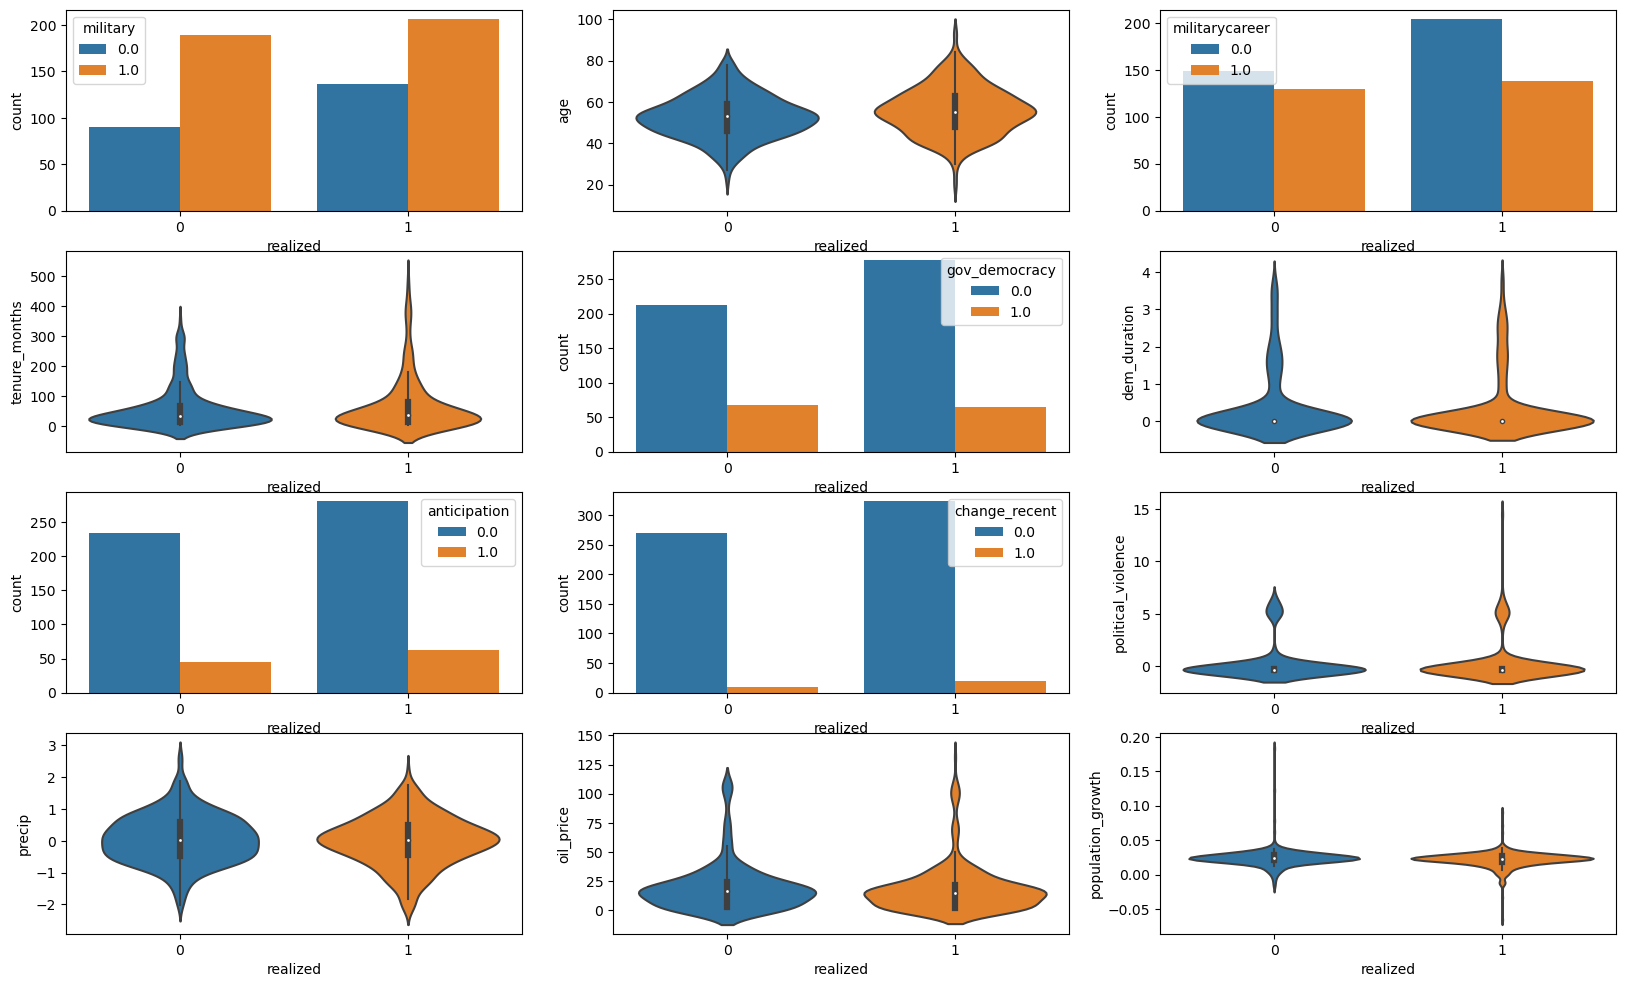

In [42]:
_,axss = plt.subplots(4,3, figsize=[20,12])
for i in range(4):
    for j in range(3):
        idx = i*3+j+7
        if len(set(complete_df.iloc[:,idx])) == 2:
            sns.countplot(x='realized',hue=complete_df.columns[idx],data=complete_df,ax=axss[i][j])
        else:
            sns.violinplot(x='realized',y=complete_df.columns[idx],data=complete_df,ax=axss[i][j])

By the frequency histogram and the violin plots, it is hard to tell which feature is deterministic in terms of predicting the coup results. Binary variables are distributed fairly balanced, and the violin plots suggest that for the numeric variables, their means, medians, and distributions are very similar no matter the coups succeded or not. The only evident difference is their skewness. We may want to model our data for more information.

In [39]:
print("There are {ratio:.2f} realized coup instances.".format(ratio=complete_df["realized"].sum()/len(complete_df)))

There are 0.55 realized coup instances.


We also explored the ratio of the realized coup observations.

It turns out that the realized and unrealized instances are fairly balanced, so there is no need to oversample any of them.